# Natural Language Processing for Customer Complaint Classification

### By: Omkar G. Kharkar

### Introduction

Customer complaint classification and routing is an important task for banks and insurance companies. This task invovles classifying complaint text data received from customers into one of several lines of business to ensure that the correct line of business is forwarded the request.

This notebook contains my Python code, images and interactive elements for classifying customer complaints into the appropriate service category. The dataset was obtained from the CFPB website and the CSV file can be downloaded here:

https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data

All work was done using Python 3.7. The machine learning models were built using Scikit-learn 0.22, and the Deep Learning models were built using Keras, on the TensorFlow 2.1.0 backend and trained on a desktop with a 4-core Intel i7 processor @ 2.90 GHz and an NVIDIA GeForce GTX 1080 GPU.

#### Problem: 
Given a dataset containing ~ 520K complaints in the form of text data, classify the complaints into one of 11 categories. It is assumed that the categories are mutually exclusive, and therefore, this is a multiclass text classification problem.

#### Methodologies:
Four different model types were built and compared for this problem:

1. **Latent Dirichlet Allocation (Topic Models) + Logistic Regression (Supervised Classification)**
2. **Long Short-Term Memory Network (LSTM) Model**
3. **Covolutional Neural Network (CNN) Model**
4. **Bi-Directional LSTM (BiLSTM) Model**

Topic Models are extremely useful for understanding which words are most associated with a certain "topic" (more explained in the section on LDA). LSTMs, CNNs and BiLSTMs have demonstrated good performance in literature for text classification and therefore, are a logical choice to start with for this analysis.

### Load all Libraries and Set Directories

First, start by loading the necessary libraries, and setting the file paths as necessary.

In [184]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

import os
import re
import numpy as np
import pandas as pd
import pickle
import time

from IPython.display import Image

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score, plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.utils import plot_model

import eli5
from eli5.lime import TextExplainer

print("Numpy Version: " + str(np.__version__))
print("Pandas Version: " + str(pd.__version__))
print("TensorFlow Version: " + str(tf.__version__))

os.getcwd()
os.chdir("C:/Users/khark_us1suft/Desktop/NLP_Customer_Complaints")
os.getcwd()

Numpy Version: 1.18.1
Pandas Version: 1.0.3
TensorFlow Version: 2.1.0


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khark_us1suft\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khark_us1suft\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'C:\\Users\\khark_us1suft\\Desktop\\NLP_Customer_Complaints'

### Exploratory Analysis

Given that this is text data, we first begin by inspecting it and the cleaning the text for use in the models. The CSV file used here was downloaded from the link above.

In [2]:
raw_data = pd.read_csv("complaints_raw.csv")
raw_data.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [3]:
raw_data.shape

(1583523, 18)

#### Eliminating Unnecessary Columns

We can eliminate some of the unnecessary columns here. The dataset is 1,583,523 rows x 18 columns wide. Since we are only trying to understanding the complaint text classification by Product, we can eliminate all the other columns except Complaint ID, Consumer Complaint narrative (the text) and Product.

In [49]:
raw_data_essentials = raw_data[["Complaint ID", "Product", "Consumer complaint narrative"]]
raw_data_essentials.columns

Index(['Complaint ID', 'Product', 'Consumer complaint narrative'], dtype='object')

In [50]:
raw_data_essentials.head(10)

,Complaint ID,Product,Consumer complaint narrative
0,3384392,Debt collection,transworld systems inc. \nis trying to collect...
1,3379500,"Credit reporting, credit repair services, or o...",NaN
2,3417821,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
3,3433198,Debt collection,"Over the past 2 weeks, I have been receiving e..."
4,3146310,Vehicle loan or lease,NaN
5,3209665,Debt collection,NaN
6,3156037,Checking or savings account,NaN
7,3214167,"Credit reporting, credit repair services, or o...",NaN
8,3212127,"Credit reporting, credit repair services, or o...",NaN
9,3416481,"Credit reporting, credit repair services, or o...",NaN


In [51]:
raw_data_essentials["Product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    387170
Mortgage                                                                        300878
Debt collection                                                                 291649
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Credit card or prepaid card                                                      75002
Checking or savings account                                                      62476
Student loan                                                                     57755
Consumer Loan                                                                    31604
Vehicle loan or lease                                                            16927
Money transfer, virtual currency, or money 

### Cleaning up the Target Column

The target column (Y-variable / Dependent variable) here is "Product". This is what we want to classify the text into, but we need to consolidate some of the categories, and rename columns for ease of use, and remove any occurrence of N/A's in a row.

In [52]:
raw_data_essentials_2 = raw_data_essentials.rename(columns={"Product":"product_group", 'Consumer complaint narrative':'text', 
                                                            "Complaint ID":"Complaint_ID"})
raw_data_essentials_2.columns

Index(['Complaint_ID', 'product_group', 'text'], dtype='object')

In [91]:
raw_data_essentials_3 = raw_data_essentials_2.dropna(inplace=False)
raw_data_essentials_3.head(10)

,Complaint_ID,product_group,text
0,3384392,Debt collection,transworld systems inc. \nis trying to collect...
2,3417821,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
3,3433198,Debt collection,"Over the past 2 weeks, I have been receiving e..."
11,3366475,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
12,3385399,Debt collection,While checking my credit report I noticed thre...
14,3446975,"Credit reporting, credit repair services, or o...",Today XX/XX/XXXX went online to dispute the in...
16,3214857,"Credit reporting, credit repair services, or o...",XXXX is reporting incorrectly to Equifax and X...
17,3417374,"Credit reporting, credit repair services, or o...",Please reverse the late payments reported on t...
18,3444592,"Credit reporting, credit repair services, or o...",I would like the credit bureau to correct my X...
19,3379924,"Credit reporting, credit repair services, or o...",MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX ...


In [99]:
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Credit reporting, credit repair services, or other personal consumer reports', 'product_group'] = 'Credit reporting'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Credit card', 'product_group'] = 'Credit card or prepaid card'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Prepaid card', 'product_group'] = 'Credit card or prepaid card'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Payday loan', 'product_group'] = 'Payday loan, title loan, or personal loan'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Virtual currency', 'product_group'] = 'Money transfer, virtual currency, or money service'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Money transfers', 'product_group'] = 'Money transfer, virtual currency, or money service'
raw_data_essentials_3 = raw_data_essentials_3[raw_data_essentials_3.product_group != 'Other financial service']

In [100]:
raw_data_essentials_3['product_group'].value_counts()

Credit reporting                                      192910
Debt collection                                       112549
Mortgage                                               64205
Credit card or prepaid card                            55853
Student loan                                           25904
Checking or savings account                            20899
Bank account or service                                14885
Money transfer, virtual currency, or money service     10011
Consumer Loan                                           9473
Vehicle loan or lease                                   8872
Payday loan, title loan, or personal loan               8747
Name: product_group, dtype: int64

In [101]:
raw_data_essentials_3.head(10)

,Complaint_ID,product_group,text
0,3384392,Debt collection,transworld systems inc. \nis trying to collect...
2,3417821,Credit reporting,I would like to request the suppression of the...
3,3433198,Debt collection,"Over the past 2 weeks, I have been receiving e..."
11,3366475,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
12,3385399,Debt collection,While checking my credit report I noticed thre...
14,3446975,Credit reporting,Today XX/XX/XXXX went online to dispute the in...
16,3214857,Credit reporting,XXXX is reporting incorrectly to Equifax and X...
17,3417374,Credit reporting,Please reverse the late payments reported on t...
18,3444592,Credit reporting,I would like the credit bureau to correct my X...
19,3379924,Credit reporting,MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX ...


In [102]:
raw_data_essentials_3.shape

(524308, 3)

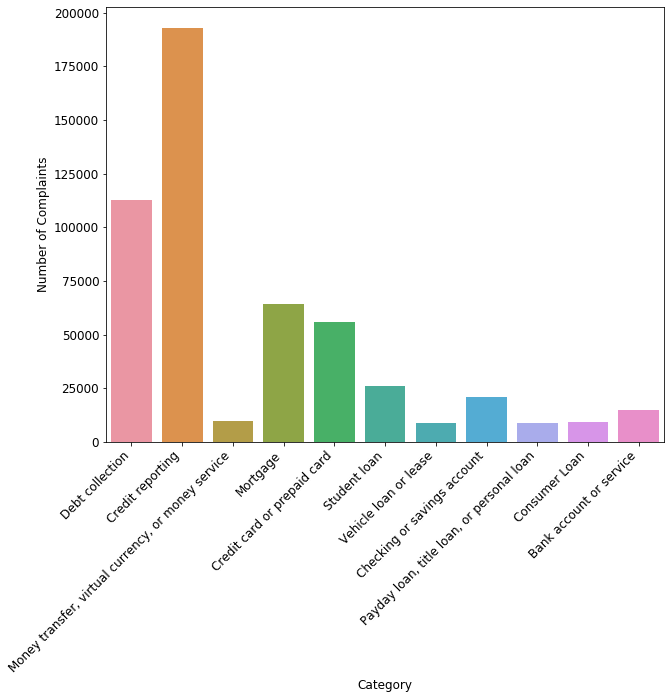

In [97]:
def complaint_category_counts():
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 12})
    chart = sns.countplot('product_group', data = raw_data_essentials_3)
    chart.set_xticklabels(chart.get_xticklabels(), 
                          rotation=45, horizontalalignment='right')
    plt.ylabel('Number of Complaints', fontsize=12)
    plt.xlabel('Category', fontsize=12)
    return

complaint_category_counts()

### Summary

Based on what we have seen so far, here are some observations:

- There are 524,308 rows, and 3 columns, with the columns labeled as "Complaint_ID", "product_group" and "text". The text column contains the text that we will be analyzing (the text is our input / X variable / independent variable)

- product_group contains 11 categories, which is our target variable (output / Y variable / dependent variable). I'll refer to it as the target variable throughout this notebook.

- At first glance, this text has symbols, as well as phrases with any number of X's that we will need to clean.

- Payday loans has the fewest number of complaints, at 8,747 total. Credit reporting has the most with 192,910 total.

### Cleaning Functions

In order to clean this text, we will need some cleaning functions to help us. Here are the functions that we will use:

1. **Remove X**: Using Regular Expressions, removes all instances of 'X' and any dates as well.
2. **Clean Text**: Removes all symbols and punctuation from the text
3. **Tokenize Text**: Tokenizes the text into words that can be used for processing
4. **Lowercase Text**: Changes the case of all words to lowercase to ensure consistent handling (Bank --> bank)
5. **Lemmatize Text**: Lemmatizes words by reducing them to their base form (Ex. walking --> walk, better --> good)
6. **Remove Stopwords**: Removes stopwords such as "the", or "I" which are commonly found in the English language.

In [103]:
def remove_x(test_string):
    new_string = re.sub(r'[X]+\/[X]+\/\d+|[X]+', "", test_string)
    return new_string

def clean_text(test_string):
    new_string = re.sub(r'[!"#$%&\'()*+,-.\/:;<=>?@\[\\\]^_`{\|}~]|[\d]+',"", test_string)
    return new_string

def tokenize_text(test_string):
    tokenizer = RegexpTokenizer(r'\w+|$[0-9.]+|\S+')
    tokenized_string = tokenizer.tokenize(test_string)
    return tokenized_string

def lowercase_text(tokenized_word_list):
    lower_case = [x.lower() for x in tokenized_word_list]
    return lower_case

def lemmatize_text(tokenized_word_list):
    lemmatized_words = []
    lemmatizer = WordNetLemmatizer()    
    for x in tokenized_word_list:
        lemmatized_words.append(lemmatizer.lemmatize(x, pos='v'))
    return lemmatized_words

def remove_stopwords(tokenized_word_list):
    clean_list = [w for w in tokenized_word_list if not w in stop_words]
    return clean_list

In [106]:
clean_data = raw_data_essentials_3.copy(deep=True)

In [107]:
clean_data['text'] = raw_data_essentials_3['text'].apply(remove_x)
clean_data['text'] = clean_data['text'].apply(clean_text)
clean_data['text'] = clean_data['text'].apply(tokenize_text)
clean_data['text'] = clean_data['text'].apply(lowercase_text)
clean_data['text'] = clean_data['text'].apply(lemmatize_text)
clean_data['text'] = clean_data['text'].apply(remove_stopwords)

In [108]:
clean_data.head(10)

,Complaint_ID,product_group,text
0,3384392,Debt collection,"[transworld, systems, inc, try, collect, debt,..."
2,3417821,Credit reporting,"[would, like, request, suppression, follow, it..."
3,3433198,Debt collection,"[past, weeks, receive, excessive, amount, tele..."
11,3366475,"Money transfer, virtual currency, or money ser...","[sell, access, event, digitally, screenshots, ..."
12,3385399,Debt collection,"[check, credit, report, notice, three, collect..."
14,3446975,Credit reporting,"[today, go, online, dispute, incorrect, person..."
16,3214857,Credit reporting,"[report, incorrectly, equifax, account, balanc..."
17,3417374,Credit reporting,"[please, reverse, late, payments, report, foll..."
18,3444592,Credit reporting,"[would, like, credit, bureau, correct, balance..."
19,3379924,Credit reporting,"[name, live, sc, dob, ss, address, file, mine,..."


### Text Length

Let's look at the average number of words per complaint, with all the cleaning performed to understand what types of complaint length we are working with.

In [233]:
clean_data["text_length"] = clean_data["text"].apply(len)
clean_data["text_length"].describe()

count    524308.000000
mean         85.418937
std          98.342507
min           0.000000
25%          30.000000
50%          57.000000
75%         106.000000
max        3408.000000
Name: text_length, dtype: float64

In [234]:
clean_data[clean_data["text_length"] == 0].describe()

,Complaint_ID,text_length
count,1.800000e+01,18.0
mean,2.904422e+06,0.0
std,5.954242e+05,0.0
min,1.409711e+06,0.0
25%,2.691988e+06,0.0
50%,3.159495e+06,0.0
75%,3.268263e+06,0.0
max,3.419201e+06,0.0


In [235]:
clean_data[clean_data["text_length"] < 11].describe()

,Complaint_ID,text_length
count,2.853100e+04,28531.000000
mean,2.782620e+06,6.818548
std,6.137551e+05,2.349095
min,1.290244e+06,0.000000
25%,2.392600e+06,5.000000
50%,2.882440e+06,7.000000
75%,3.302444e+06,9.000000
max,3.629728e+06,10.000000


In [236]:
clean_data[clean_data["text_length"] < 6].describe()

,Complaint_ID,text_length
count,8.027000e+03,8027.000000
mean,2.835953e+06,3.801545
std,6.118315e+05,1.159521
min,1.290851e+06,0.000000
25%,2.474476e+06,3.000000
50%,2.964043e+06,4.000000
75%,3.349972e+06,5.000000
max,3.619108e+06,5.000000


In [237]:
clean_data[clean_data["text_length"] >= 5].describe()

,Complaint_ID,text_length
count,5.192300e+05,519230.000000
mean,2.689930e+06,86.223951
std,6.180276e+05,98.483059
min,1.290155e+06,5.000000
25%,2.260710e+06,31.000000
50%,2.807454e+06,58.000000
75%,3.190828e+06,107.000000
max,3.630812e+06,3408.000000


In [238]:
clean_data[clean_data["text_length"] == 5].head(15)

,Complaint_ID,product_group,text,text_length
24,3415907,Credit reporting,"[victim, identity, theft, previously, state]",5
34,3379049,Credit reporting,"[previous, address, report, behalf, incorrect]",5
2622,3157369,Credit reporting,"[make, aware, data, breach, experian]",5
3757,3161005,Credit reporting,"[experian, show, debt, report, incorrectly]",5
3812,3391579,Credit reporting,"[literally, th, attempt, fix, problem]",5
4410,3167924,Credit reporting,"[knowledge, account, attachment, body, thank]",5
5697,3328410,Debt collection,"[balance, around, want, pay, around]",5
5953,3165740,Credit reporting,"[inquire, credit, report, recognize, authorize]",5
8783,3127297,Credit reporting,"[card, update, balance, credit, bureaus]",5
10117,3154793,Credit reporting,"[victim, credit, report, inquiry, fraud]",5


#### Filtering Text by Length.

We still have text with a length of 0, which we will need to remove. There are only 18 complaints which still have no text. Additionally, I will also restrict this analysis to complaints that have at least 5 or more meaningful words in each complaint to prevent model overfitting.

In [239]:
clean_data = clean_data[clean_data["text_length"] >= 5]
print(clean_data.shape)

(519230, 4)


In [240]:
clean_data.head(10)

,Complaint_ID,product_group,text,text_length
0,3384392,Debt collection,"[transworld, systems, inc, try, collect, debt,...",9
2,3417821,Credit reporting,"[would, like, request, suppression, follow, it...",33
3,3433198,Debt collection,"[past, weeks, receive, excessive, amount, tele...",29
11,3366475,"Money transfer, virtual currency, or money ser...","[sell, access, event, digitally, screenshots, ...",24
12,3385399,Debt collection,"[check, credit, report, notice, three, collect...",90
14,3446975,Credit reporting,"[today, go, online, dispute, incorrect, person...",11
16,3214857,Credit reporting,"[report, incorrectly, equifax, account, balanc...",31
17,3417374,Credit reporting,"[please, reverse, late, payments, report, foll...",22
18,3444592,Credit reporting,"[would, like, credit, bureau, correct, balance...",8
19,3379924,Credit reporting,"[name, live, sc, dob, ss, address, file, mine,...",26


### Pickle Files

Now, the text data is in the format that it needs to be in. We only need to do the data pre-processing once, so let's save the file as a pickle object. (I have pickled or saved several model objects throughout this notebook.)

In [241]:
clean_data_file = open('clean_complaints_text_ready_for_modeling.pkl', 'ab') 
pickle.dump(clean_data, clean_data_file)                      
clean_data_file.close()
print("Pickling Done !")

Pickling Done !


In [242]:
clean_data["text_length"].describe()

count    519230.000000
mean         86.223951
std          98.483059
min           5.000000
25%          31.000000
50%          58.000000
75%         107.000000
max        3408.000000
Name: text_length, dtype: float64

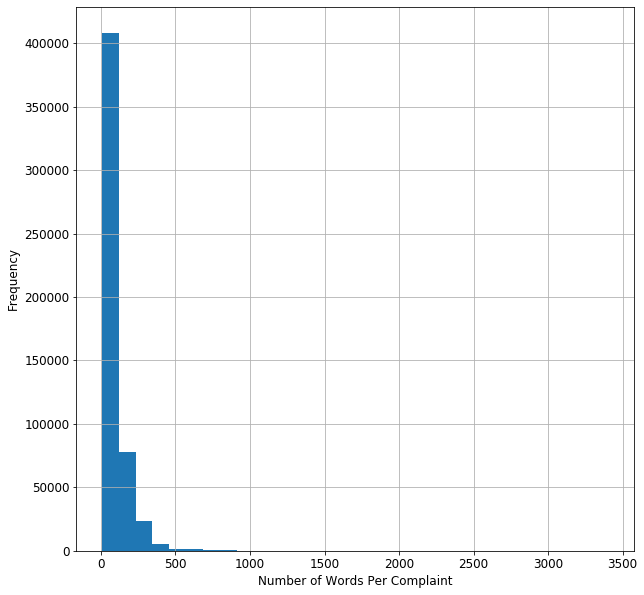

In [135]:
def complaint_length_histogram():
    clean_data["text_length"].hist(bins=30, figsize=(10,10))
    plt.xlabel("Number of Words Per Complaint", fontsize=12)
    plt.ylabel("Frequency",fontsize=12)
    return

complaint_length_histogram()

In [243]:
clean_data[clean_data["text_length"] <= 300].describe()

,Complaint_ID,text_length
count,5.028040e+05,502804.000000
mean,2.685146e+06,74.285328
std,6.195408e+05,60.964615
min,1.290155e+06,5.000000
25%,2.251070e+06,30.000000
50%,2.802680e+06,56.000000
75%,3.187622e+06,100.000000
max,3.630812e+06,300.000000


### Summary

#### Complaint Length:

This information will be useful later on to understand how many words per complaint we can use for the deep learning models. Note that 96% of complaints are less than 300 words, so this is a good choice for complaint length for the deep learning models.

Now we can begin modeling the data. We have 519,230 (~520K) complaints and 4 columns (Complaint_ID, product_group, text and text_length) for analysis.

### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is an unsupervised statistical modeling technique that allows us to understand what specific gropus of words or "topics" correspond to a particular category. Using these topic vectors, we can transform the data and use a supervised classification method to see how the complaints can be classified.

In this case, we will be using LDA to get the topic vectors, then passing the topic vectors to a Logistic Regression classifier to make predictions. The image below shows an example of how this process works.

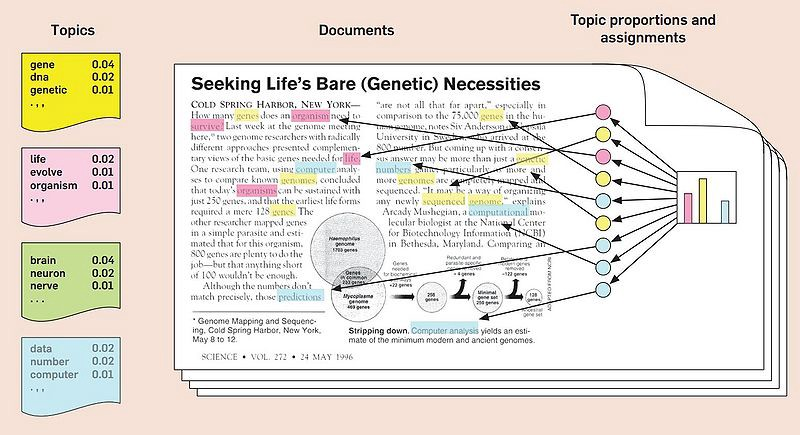

In [143]:
Image("LDA.jpeg") #[1]

In [144]:
# Latent Dirichlet Allocation
def get_LDA_model(data_set, num_topics, passes):
    start_time = time.time()
    text_data = list(data_set['text'])
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
   
    LDA_model = gensim.models.ldamulticore.LdaMulticore(
                               corpus=corpus,
                               num_topics=num_topics,
                               id2word=dictionary,
                               workers=6,
                               passes=passes)
    
    topics = LDA_model.print_topics(num_words=10)
    for x in topics:
        print(x)
        print("\n")
    print("--- Time Taken: %s seconds ---" % (time.time() - start_time))
    return LDA_model, topics, corpus, dictionary

LDA_model, topics, corpus, dictionary = get_LDA_model(clean_data, 11, 10)

(0, '0.083*"report" + 0.081*"credit" + 0.035*"account" + 0.027*"information" + 0.025*"remove" + 0.021*"dispute" + 0.016*"file" + 0.014*"equifax" + 0.011*"experian" + 0.009*"company"')


(1, '0.053*"claim" + 0.020*"report" + 0.012*"compliance" + 0.012*"court" + 0.010*"allege" + 0.010*"compliant" + 0.009*"document" + 0.008*"full" + 0.008*"plaintiff" + 0.008*"complaint"')


(2, '0.064*"consumer" + 0.055*"identity" + 0.054*"inquiry" + 0.051*"information" + 0.046*"theft" + 0.042*"report" + 0.029*"block" + 0.022*"agency" + 0.019*"victim" + 0.018*"section"')


(3, '0.055*"loan" + 0.046*"payment" + 0.030*"payments" + 0.030*"pay" + 0.023*"make" + 0.019*"interest" + 0.014*"amount" + 0.013*"would" + 0.013*"month" + 0.010*"due"')


(4, '0.037*"mortgage" + 0.026*"loan" + 0.015*"home" + 0.011*"modification" + 0.010*"property" + 0.009*"well" + 0.009*"bank" + 0.009*"document" + 0.009*"request" + 0.008*"us"')


(5, '0.058*"call" + 0.032*"tell" + 0.024*"say" + 0.020*"get" + 0.020*"would" + 0.018*"ask" +

### Visualize using pyLDAvis

The pyLDAvis tool is very useful for helping to visualize which topics are associated with certain words. This is a key part of model interpretability, as it can help users to understand where the predictions on the input data come from.

In [145]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

### Summary of LDA Visualizer

(The visual above is interactive in a Jupyter notebook.)

There is a lot of overlap between the key words found in Topics 4, 5, 6, 9, 10, 11. This warrants further examination. A possible step in the future would be to consider using 2-grams for 3-grams.

In [146]:
# Pickle the LDA model objects
with open('LDA_model.pkl', 'wb') as f:
    pickle.dump(LDA_model, f)
with open('complaint_data.pkl', 'wb') as f:
    pickle.dump(corpus, f)
with open('topics_data.pkl', 'wb') as f:
    pickle.dump(topics, f)
dictionary.save('dictionary.gensim')

## Building a Model using LDA Topic Vectors

We can use the LDA Topic Vectors listed above to build a multiclass classification model. First, the input data text is transformed into the topic vector format.

In [147]:
# Training Vectors
start_time = time.time()
text_data = list(clean_data['text'])

training_vectors = []
for i in range(len(text_data)):
    top_topics = LDA_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vectors = [top_topics[i][1] for i in range(11)]
    training_vectors.append(topic_vectors)
print("--- Time Taken: %s seconds ---" % (time.time() - start_time))

--- Time Taken: 267.9429044723511 seconds ---


Next, we can build a Multi-class Logistic Regression Classifier that attempts to use the transformed topic vector as inputs and make predictions.

In [148]:
# Build a Logistic Regression Model using LDA Vectors
le = LabelEncoder()
scaler = StandardScaler()
Y = le.fit_transform(clean_data['product_group'])
X = np.array(training_vectors)
X_scaled = scaler.fit_transform(X)

X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(X_scaled, Y, test_size = 0.20, random_state = 1234)

lr_cv = LogisticRegressionCV(Cs=5, 
                          class_weight='balanced', 
                          cv=5,                     
                          max_iter=300, 
                          multi_class='multinomial',
                          random_state=1234,
                          scoring='roc_auc_ovr_weighted', 
                          solver='saga')

start_time = time.time()
lr_cv.fit(X_train_lr, Y_train_lr)
print("--- Time Taken: %s seconds ---" % (time.time() - start_time))

--- Time Taken: 81.23696255683899 seconds ---


In [149]:
print('Average Cross-Validation AUC OVR Weighted: ', lr_cv.scores_[1].mean(axis=0).max())

Average Cross-Validation AUC OVR Weighted:  0.919466133161443


In [150]:
with open('LR_CV_model.pkl', 'wb') as f:
    pickle.dump(lr_cv, f)
with open('X_LR.pkl', 'wb') as f:
    pickle.dump(X_scaled, f)
with open('Y_LR.pkl', 'wb') as f:
    pickle.dump(Y, f)

### Plot Multi-Class Confusion Matrix

We can plot the confusion matrix to understand where the strengths and weaknesses of the Logistic Regression classifier are. Based on the results we are seeing from the cross-validated Logistic Regression, **Debt collection** and **Credit reporting** seem to have a lot of misclassifications between each other as well as the **Vehicle loan or lease** category. Additionally, **Money transfers** and **Bank accounts** have a lot of misclassifications as well. It would be interesting to see the key words from the LDA visualizer above which correspond to both of these topics to get a better understanding of what terms could be causing the misclassification.

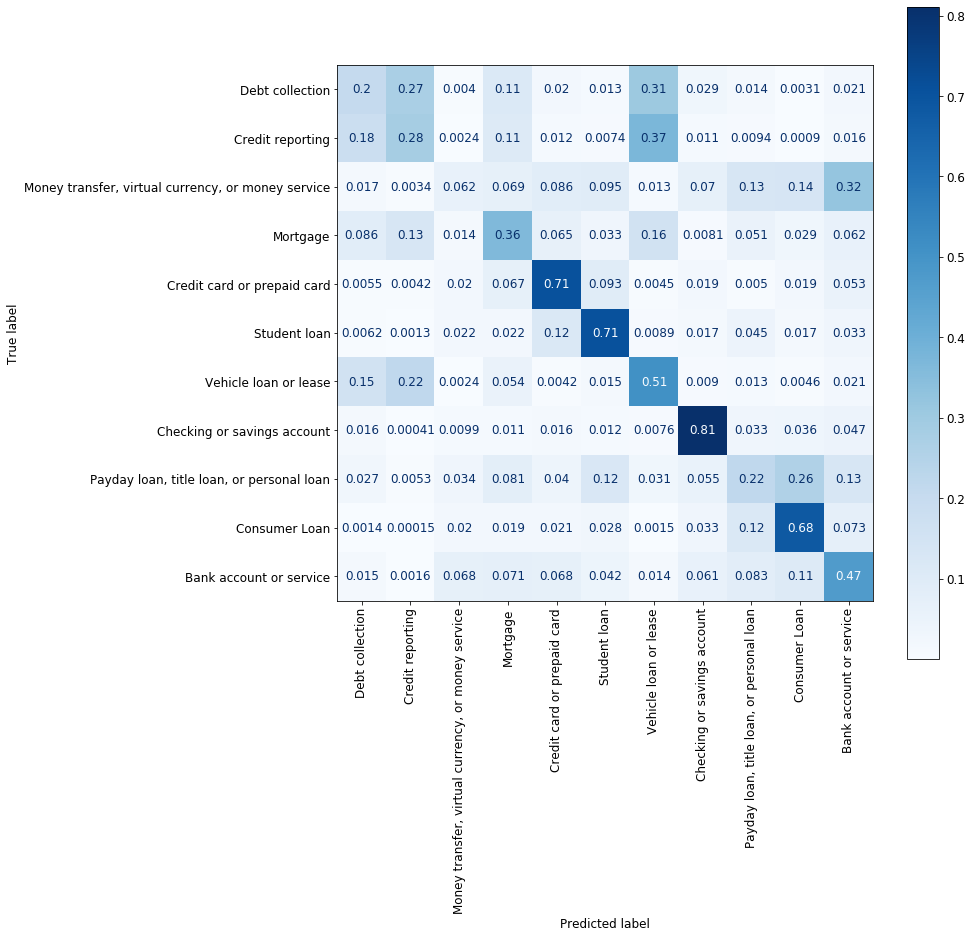

In [216]:
class_names = clean_data['product_group'].unique()
disp = plot_confusion_matrix(lr_cv, X_train_lr, Y_train_lr, display_labels=class_names, cmap=plt.cm.Blues, normalize='true',
                            xticks_rotation='vertical').figure_.set_size_inches(12,12)

### Deep Learning Models in Keras
 
Deep Learning methods, such as LSTMs, CNNs and BiLSTMs have shown good results for several Natural Language Processing tasks, including Text Classification.

For all the Deep Learning methods below, each model was first trained using a Training & Validation partition (80/20 split). Second, X_train was used for the cross-validation process. X_test acts as a holdout that could hypothetically be used after the model of choice has been selected using the cross-validation score.

Given computational constraints, all deep learning models were trained for only 5 epochs each, to ensure that cross-validation ran in a reasonable amount of time.

**Note:** In a real-world exercise, it is important to consider the tradeoff between the number of samples and whether cross-validation is required. For this exercise, I used cross-validation since it is a good way to measure out-of-sample performance. However, given a sufficiently large dataset, the trade-off between performance and computational overhead required is an important consideration to be mindful of prior to using cross-validation for deep learning models.

### LSTM Model in Keras

First, we can try using an LSTM Model in Keras to model the text as a sequence. LSTM models have the following general structure, shown below.

With the LSTM model, we have to specify the complaint length that should be ued for each entry. Given that 96% of complaints are less than 300 words, we can use this our sequence length variable below.

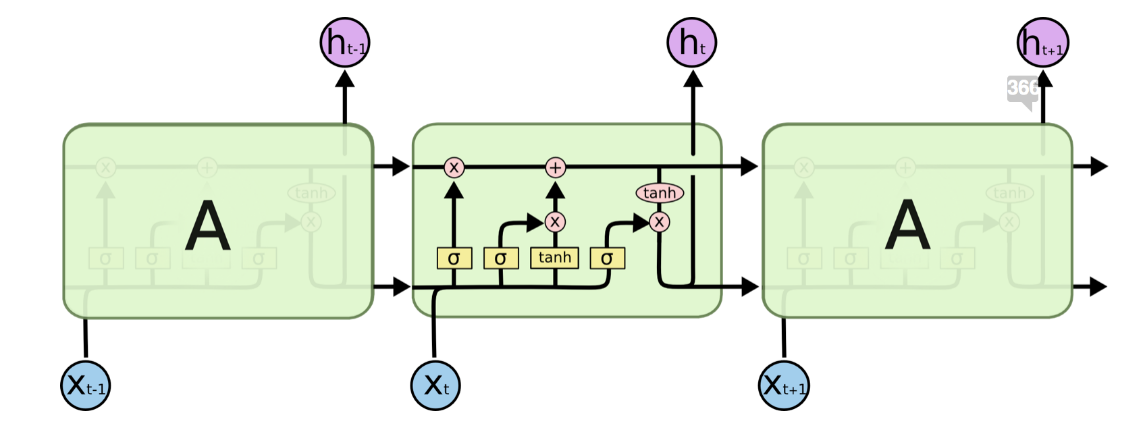

In [152]:
Image("LSTM_2.png", height=500, width=1000) #[2]

In [153]:
def LSTMClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Shape of Input Data: ', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)

    print('Shape of Output Data', Y_dl.shape)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    
    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    
    start_time = time.time()
    LSTM_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    print("--- Training Time Taken: %s seconds ---" % (time.time() - start_time))
    return model, LSTM_Runs

In [154]:
LSTM_Model, LSTM_Runs = LSTMClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Shape of Input Data:  (519230, 300)
Shape of Output Data (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 11)                1111      
Total params: 10,081,511
Trainable params: 10,081,511
Non-trainable params: 0
_________________________________________________________________
None
Train on 332307 samples, validate on 83077 samples
Epoch 1/5
332307/332307 [==============================] - 347s 1ms/sample - loss: 1.0349 - precision: 0.8260 - recall: 0.5635 - auc: 0.9403 - val_loss: 0.7309 - val_precis

In [155]:
LSTM_model_json = LSTM_Model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(LSTM_model_json)
LSTM_Model.save_weights("LSTM_model.h5")
print("Saved model to disk")

Saved model to disk


This is a view of what the LSTM Network structure looks like:

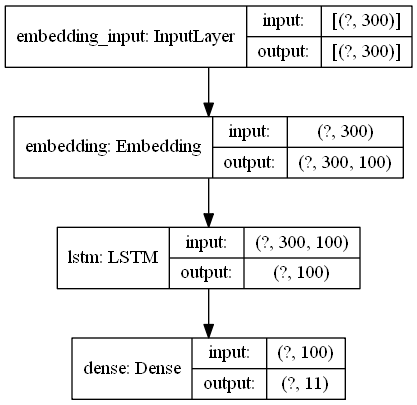

In [156]:
plot_model(LSTM_Model, to_file='LSTM_Model_Architecture.png', show_shapes=True)

In [157]:
def LSTMClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)
    
    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()        
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
        model.add(Dense(11, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [158]:
LSTM_CV_Model, LSTM_CV_Scores = LSTMClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Input Data Shape: (519230, 300)
Output Data Shape: (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 10,081,511
Trainable params: 10,081,511
Non-trainable params: 0
_________________________________________________________________
None
Training for Fold 1
Train on 332307 samples
Epoch 1/5
332307/332307 [==============================] - 329s 991us/sample - loss: 1.0597 - auc: 0.9379
Epoch 2/5
332307/332307 [==============================] - 327s 984us/sample

In [159]:
LSTM_CV_model_json = LSTM_CV_Model.to_json()
with open("LSTM_CV_model.json", "w") as json_file:
    json_file.write(LSTM_CV_model_json)
LSTM_CV_Model.save_weights("LSTM_CV_model.h5")
print("Saved model to disk")

Saved model to disk


In [160]:
print(LSTM_CV_Scores)

[0.97983134, 0.9815013, 0.982545, 0.97861874, 0.9815707]


### Convolutional Neural Network Classifier

Next, using a 1D Covolutional Neural Network (CNN), we can also try to predict which category the complaint is assigned to.

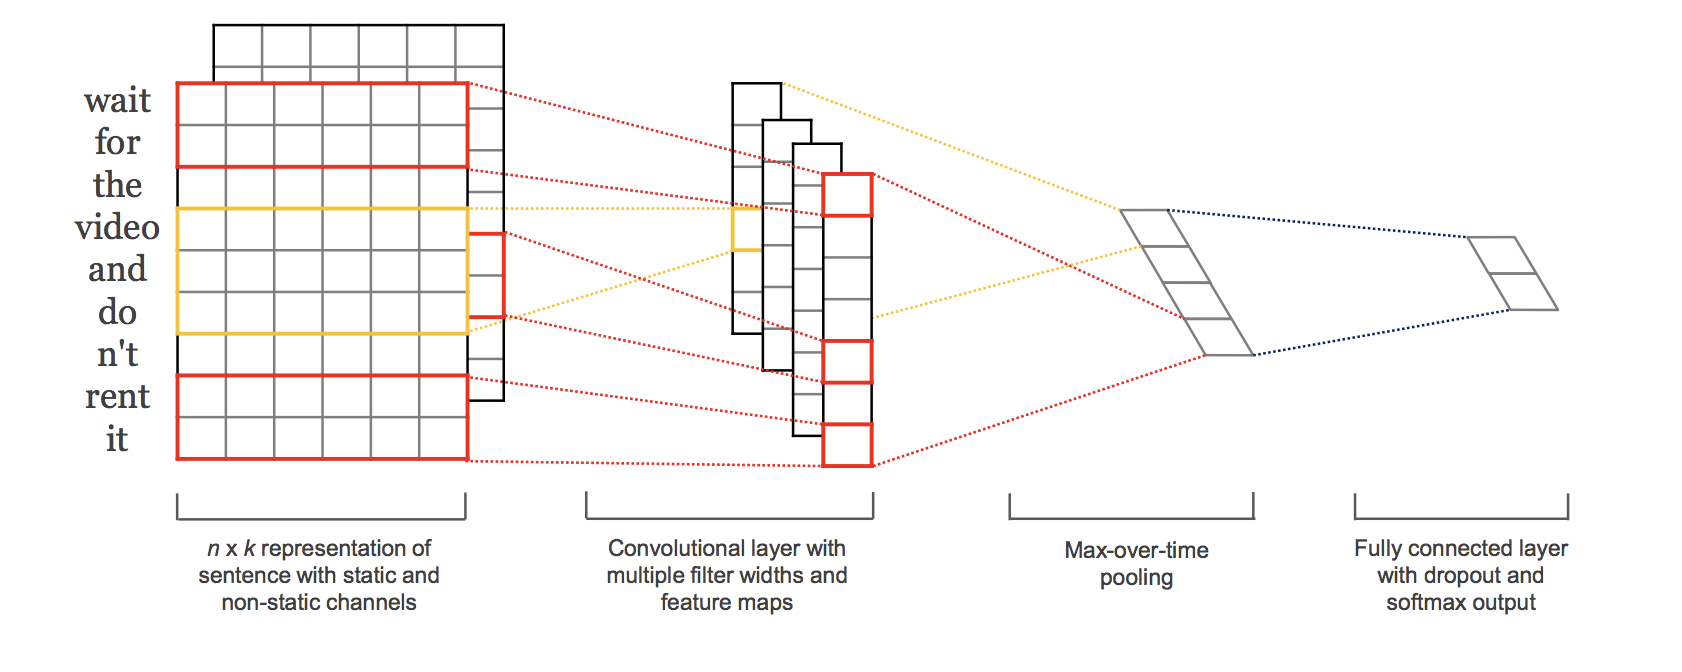

In [161]:
Image("CNN.png", width=800, height=400) #[3]

In [162]:
def CNNClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())

    CNN_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    return model, CNN_Runs

In [163]:
CNN_Model, CNN_Runs = CNNClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Input Data Shape: (519230, 300)
Output Data Shape: (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          10000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 293, 32)           25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 146, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4672)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 11)                51403     
Total params: 10,077,035
Trainable params: 10,077,035
Non-trainable params: 0
__________________________________

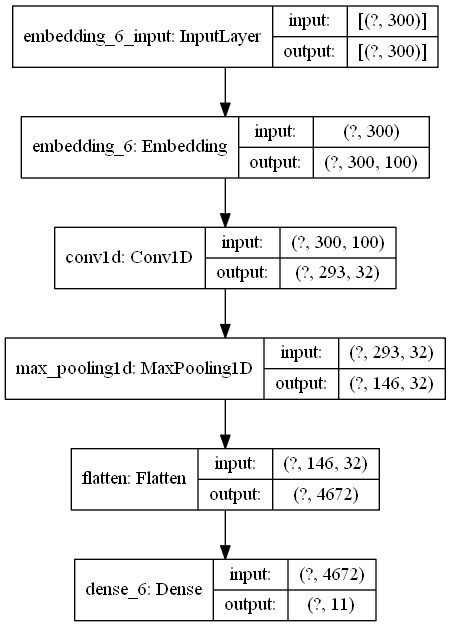

In [164]:
plot_model(CNN_Model, to_file='CNN_Model.png', show_shapes=True)

In [165]:
def CNNClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)
    
    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(11, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [166]:
CNN_CV_Model, CNN_CV_Scores = CNNClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Input Data Shape: (519230, 300)
Output Data Shape: (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          10000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 293, 32)           25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 146, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4672)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 11)                51403     
Total params: 10,077,035
Trainable params: 10,077,035
Non-trainable params: 0
_________________________________

In [167]:
print(CNN_CV_Scores)

[0.97512376, 0.9713927, 0.9756321, 0.9754778, 0.9749919]


In [168]:
CNN_CV_model_json = CNN_CV_Model.to_json()
with open("CNN_CV_model.json", "w") as json_file:
    json_file.write(CNN_CV_model_json)
CNN_CV_Model.save_weights("CNN_CV_model.h5")
print("Saved model to disk")

Saved model to disk


### Bi-Directional LSTM Classifier

Using a Bi-Directional LSTM, information is passed from the network in 2 directions to understand the meaning of the complaint text. The network makes a pass from front to back and then from back to front. I'll try using a 25-node LSTM layer here instead of the 100 node layer shown above, with a stronger dropout to reduce training time.

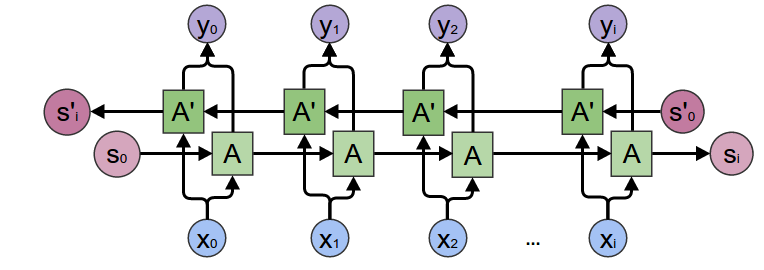

In [169]:
Image("BiLSTM.png") #[4]

In [170]:
def BiLSTMClassifier(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))

    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)

    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)

    print('Output Data Shape:', Y_dl.shape)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    metrics = [Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
    model.add(Bidirectional(LSTM(25, dropout=0.4, recurrent_dropout=0.4)))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())

    BiLSTM_Runs = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])
    return model, BiLSTM_Runs

In [171]:
BiLSTM_Model, BiLSTM_Runs = BiLSTMClassifier(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Input Data Shape: (519230, 300)
Output Data Shape: (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 100)          10000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50)                25200     
_________________________________________________________________
dense_12 (Dense)             (None, 11)                561       
Total params: 10,025,761
Trainable params: 10,025,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 332307 samples, validate on 83077 samples
Epoch 1/5
332307/332307 [==============================] - 670s 2ms/sample - loss: 1.2995 - precision: 0.7920 - recall: 0.4240 - auc: 0.9069 - val_loss: 0.9860 - val_precision

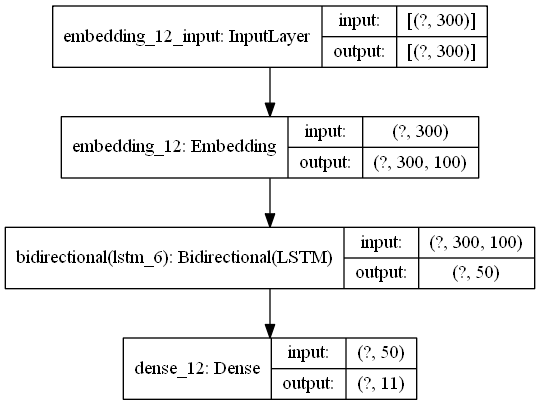

In [172]:
plot_model(BiLSTM_Model, to_file='BiLSTM_Model.png', show_shapes=True)

In [173]:
BiLSTM_model_json = BiLSTM_Model.to_json()
with open("BiLSTM_model.json", "w") as json_file:
    json_file.write(BiLSTM_model_json)
BiLSTM_Model.save_weights("BiLSTM_model.h5")
print("Saved model to disk")

Saved model to disk


In [174]:
def BiLSTMClassifierCV(max_words, max_sequence_length, embedding_dim, epochs, batch_size):
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(clean_data['text'].values)

    word_index = tokenizer.word_index
    print('Unique tokens: ' + str(len(word_index)))
    X_dl = tokenizer.texts_to_sequences(clean_data['text'].values)
    X_dl = pad_sequences(X_dl, maxlen=max_sequence_length)
    print('Input Data Shape:', X_dl.shape)
    
    dle = LabelEncoder()
    Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))

    print('Output Data Shape:', Y_dl.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(X_dl, Y_dl, test_size = 0.20, random_state = 1234)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    metrics = [AUC(name='auc')]
    auc_per_fold = []
    fold_index = 1
    for train, test in kfold.split(X_train, Y_train):
        print()
        model = Sequential()
        model.add(Embedding(max_words, embedding_dim, input_length=X_dl.shape[1]))
        model.add(Bidirectional(LSTM(25, dropout=0.4, recurrent_dropout=0.4)))
        model.add(Dense(11, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
        if(fold_index == 1):
            print(model.summary())
        print("Training for Fold " + str(fold_index))
        model.fit(X_train[train], Y_train[train], epochs=epochs, batch_size=batch_size, validation_split=0)
        scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
        auc_per_fold.append(scores[1])
        fold_index += 1
    print('Average AUC: ' + str(np.mean(auc_per_fold)))

    return model, auc_per_fold

In [175]:
BiLSTM_CV_Model, BiLSTM_CV_Scores = BiLSTMClassifierCV(max_words = 100000, max_sequence_length = 300, embedding_dim = 100, epochs = 5, batch_size = 512)

Unique tokens: 165283
Input Data Shape: (519230, 300)
Output Data Shape: (519230, 11)
(415384, 300) (415384, 11)
(103846, 300) (103846, 11)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          10000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                25200     
_________________________________________________________________
dense_13 (Dense)             (None, 11)                561       
Total params: 10,025,761
Trainable params: 10,025,761
Non-trainable params: 0
_________________________________________________________________
None
Training for Fold 1
Train on 332307 samples
Epoch 1/5
332307/332307 [==============================] - 649s 2ms/sample - loss: 1.2337 - auc: 0.9158
Epoch 2/5
332307/332307 [==============================] - 644s 2ms/sample - 

In [176]:
BiLSTM_CV_model_json = BiLSTM_CV_Model.to_json()
with open("BiLSTM_CV_model.json", "w") as json_file:
    json_file.write(BiLSTM_CV_model_json)
BiLSTM_CV_Model.save_weights("BiLSTM_CV_Model.h5")
print("Saved model to disk")

Saved model to disk


In [177]:
print(BiLSTM_CV_Scores)

[0.97583455, 0.97453004, 0.97576857, 0.9737298, 0.9729572]


### Saving Cross-Validated Deep Learning Models

All 3 cross-validated Deep Learning models are saved to an h5 file here:

In [178]:
LSTM_CV_Model.save("LSTM_CV_Model_Full.h5")
BiLSTM_CV_Model.save("BiLSTM_CV_Model_Full.h5")
CNN_CV_Model.save("CNN_CV_Model_Full.h5")
print("Done !")

Done !


### Deep Learning Model Interpretability

Using Eli5's TextExplainer, a user can pass ina sample complaint, tokenize it and understand, based on the words, why a particular complaint was assigned to a category by the deep learning model. Here is a sample complaint, processed and used by the models to show interpretability. This allows us to understand how a model is making predictions at the observation level.

For all deep learning models trained, the Softmax activation function was used in the final layer to ensure that all multi-class probabilities sum to 1 for each row of data. This is a requirement for the TextExplainer model.

Here is a sample, fictional complaint that demonstrates how the TextExplainer works.

In [179]:
complaint = 'I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account. The following Visa credit card accounts do not belong to me: '

def predict_proba(t, m):

    def keras_input(complaint):
        nc_seq = t.texts_to_sequences(complaint)
        nc_padded = pad_sequences(nc_seq, maxlen=300)
        predicted = m.predict(nc_padded)
        return predicted

    return keras_input

dle = LabelEncoder()
Y_dl = to_categorical(dle.fit_transform(clean_data['product_group']))
tokenizer = Tokenizer(num_words=100000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(clean_data['text'].values)

### LSTM Prediction Explanations

In [185]:
TE = TextExplainer(random_state=1234)
TE.fit(complaint, predict_proba(tokenizer, LSTM_CV_Model))
TE.show_prediction(target_names=list(dle.classes_))

### CNN Model Prediction Explanations

In [186]:
TE2 = TextExplainer(random_state=1234)
TE2.fit(complaint, predict_proba(tokenizer, CNN_CV_Model))
TE2.show_prediction(target_names=list(dle.classes_))

### BiLSTM Model Prediction Explanations

In [187]:
TE3 = TextExplainer(random_state=1234)
TE3.fit(complaint, predict_proba(tokenizer, BiLSTM_CV_Model))
TE3.show_prediction(target_names=list(dle.classes_))

### Comparing Models


Here are the average cross-validation AUC scores for all the models that were tested above, rounded to 4 decimal places: <br><br>

LDA + Logistic Regression: **0.9195**<br>
LSTM:     **0.9808**<br>
CNN:      **0.9745**<br>
BiLSTM:   **0.9746**<br><br>

The Convolutional Neural Network would be a good choice to proceed with, since it achieves a good AUC with minimal training time.

### Future Considerations

Given the analysis performed here, there several follow-up items that I would suggest as next steps to this problem:

- **Attention Layers** - Experiment with adding attention layers to improve model performance <br><br>

- **Transformer Neural Network** - Given time and computational power, one possible approach would be to approach this problem with a transformer such as BERT, ELMO, or GPT-2<br><br>

- **Semantic Role Labeling** - It would be interesting to analyze the more complex and lengthy complaints using semantic role labeling, and potentially researching how this can improve text classification. This would help in understanding how multiple customer service agents followed up with a customer's requests and the steps they took to resolve a complaint. This way, we would be able to see who was able to impact whom in a given complaint.<br><br>

- **Scaling Up** - Given that this data was ~ 520K records, large-scale data management was not required. In the future, for a dataset consisting of ~ 1M or more records, tools such as PySpark and SparkNLP can certainly improve performance and will be necessary to some degree. Additionally, GPU computation on an AWS, Azure or Google Cloud instance could significantly improve training times for models.<br><br>

### References

Images were obtained from:

#[1] [LDA Online Image].Topic modelling with Latent Dirichlet Allocation (LDA) in Pyspark.https://medium.com/@connectwithghosh/topic-modelling-with-latent-dirichlet-allocation-lda-in-pyspark-2cb3ebd5678e

#[2] Olah, C.(2015).[LSTM Online Image].Understanding LSTM Networks.https://colah.github.io/posts/2015-08-Understanding-LSTMs/

#[3] Kim, Y.(2014).Figure 1: Model architecture with two channels for an example sentence.[Online Image]. Convolutional Neural Networks for Sentence Classification. https://arxiv.org/pdf/1408.5882.pdf?source=post_page

#[4] Olah, C.(2015).Zipped Left & Right Accumulating Map = Bidirectional RNN.[Online Image].Neural Networks, Types, and Functional Programming.http://colah.github.io/posts/2015-09-NN-Types-FP/
